# Author : Owen Nda Diche

# Churn Prediction — Random Forest Classifier

## Objective
Train a **Random Forest Classifier** to predict customer churn using the final prepared dataset: `data_for_predictions.csv`.

## Why these evaluation metrics?
Churn prediction is often **imbalanced** (fewer churners than non-churners), so accuracy alone can be misleading.

We use:
- **Recall (Churn class)**: how many actual churners we correctly identify (important for retention targeting).
- **Precision (Churn class)**: how many predicted churners are truly churners (controls wasted retention offers).
- **F1-score**: balances precision and recall.
- **ROC-AUC**: evaluates ranking quality across all thresholds, robust to threshold choice.
- **Confusion Matrix**: shows exact counts of correct/incorrect predictions.


In [42]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import precision_recall_curve

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, ConfusionMatrixDisplay, classification_report,
    RocCurveDisplay
)

pd.set_option("display.max_columns", 200)

DATA_PATH = "data_for_predictions.csv"
df = pd.read_csv(DATA_PATH)

# Drop accidental index columns
drop_cols = [c for c in df.columns if c.lower().startswith("unnamed")]
df = df.drop(columns=drop_cols, errors="ignore")
print("Dropped:", drop_cols)

print("Shape:", df.shape)
display(df.head())


Dropped: ['Unnamed: 0']
Shape: (14606, 63)


,id,cons_12m,cons_gas_12m,cons_last_month,forecast_cons_12m,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_off_peak,forecast_price_energy_peak,forecast_price_pow_off_peak,has_gas,imp_cons,margin_gross_pow_ele,margin_net_pow_ele,nb_prod_act,net_margin,pow_max,var_year_price_off_peak_var,var_year_price_peak_var,var_year_price_mid_peak_var,var_year_price_off_peak_fix,var_year_price_peak_fix,var_year_price_mid_peak_fix,var_year_price_off_peak,var_year_price_peak,var_year_price_mid_peak,var_6m_price_off_peak_var,var_6m_price_peak_var,var_6m_price_mid_peak_var,var_6m_price_off_peak_fix,var_6m_price_peak_fix,var_6m_price_mid_peak_fix,var_6m_price_off_peak,var_6m_price_peak,var_6m_price_mid_peak,churn,offpeak_diff_dec_january_energy,offpeak_diff_dec_january_power,off_peak_peak_var_mean_diff,peak_mid_peak_var_mean_diff,off_peak_mid_peak_var_mean_diff,off_peak_peak_fix_mean_diff,peak_mid_peak_fix_mean_diff,off_peak_mid_peak_fix_mean_diff,off_peak_peak_var_max_monthly_diff,peak_mid_peak_var_max_monthly_diff,off_peak_mid_peak_var_max_monthly_diff,off_peak_peak_fix_max_monthly_diff,peak_mid_peak_fix_max_monthly_diff,off_peak_mid_peak_fix_max_monthly_diff,tenure,months_activ,months_to_end,months_modif_prod,months_renewal,channel_MISSING,channel_ewpakwlliwisiwduibdlfmalxowmwpci,channel_foosdfpfkusacimwkcsosbicdxkicaua,channel_lmkebamcaaclubfxadlmueccxoimlema,channel_usilxuppasemubllopkaafesmlibmsdf,origin_up_kamkkxfxxuwbdslkwifmmcsiusiuosws,origin_up_ldkssxwpmemidmecebumciepifcamkci,origin_up_lxidpiddsbxsbosboudacockeimpuepw
0,24011ae4ebbe3035111d65fa7c15bc57,0.000000,4.739944,0.000000,0.000000,0.0,0.444045,0.114481,0.098142,40.606701,1,0.00000,25.44,25.44,2,678.99,43.648,0.000061,2.627605e-05,0.000440,1.102785,49.550703,22.022535,1.102846,4.955073e+01,22.022975,0.000131,4.100838e-05,9.084737e-04,2.086294,99.530517,44.235794,2.086425,9.953056e+01,4.423670e+01,1,0.020057,3.700961,0.024038,0.034219,0.058257,18.590255,7.450670,26.040925,0.060550,0.085483,0.146033,44.266930,8.145775,44.26693,3,30,5,2,6,0,0,1,0,0,0,0,1
1,d29c2c54acc38ff3c0614d0a653813dd,3.668479,0.000000,0.000000,2.280920,0.0,1.237292,0.145711,0.000000,44.311378,0,0.00000,16.38,16.38,1,18.89,13.800,0.000005,6.089453e-04,0.000000,0.006465,0.000000,0.000000,0.006470,6.089453e-04,0.000000,0.000003,1.217891e-03,0.000000e+00,0.009482,0.000000,0.000000,0.009485,1.217891e-03,0.000000e+00,0,-0.003767,0.177779,0.142485,0.007124,0.149609,44.311375,0.000000,44.311375,0.151367,0.085483,0.151367,44.444710,0.000000,44.44471,7,76,7,76,4,1,0,0,0,0,1,0,0
2,764c75f661154dac3a6c254cd082ea7d,2.736397,0.000000,0.000000,1.689841,0.0,1.599009,0.165794,0.087899,44.311378,0,0.00000,28.60,28.60,1,6.60,13.856,0.000006,2.558511e-07,0.000000,0.007662,0.000000,0.000000,0.007668,2.558511e-07,0.000000,0.000004,9.450150e-08,0.000000e+00,0.000000,0.000000,0.000000,0.000004,9.450150e-08,0.000000e+00,0,-0.004670,0.177779,0.082090,0.088421,0.170512,44.385450,0.000000,44.385450,0.084587,0.089162,0.172468,44.444710,0.000000,44.44471,6,68,3,68,8,0,0,1,0,0,1,0,0
3,bba03439a292a1e166f80264c16191cb,3.200029,0.000000,0.000000,2.382089,0.0,1.318689,0.146694,0.000000,44.311378,0,0.00000,30.22,30.22,1,25.46,13.200,0.000005,0.000000e+00,0.000000,0.006465,0.000000,0.000000,0.006470,0.000000e+00,0.000000,0.000003,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000003,0.000000e+00,0.000000e+00,0,-0.004547,0.177779,0.151210,0.000000,0.151210,44.400265,0.000000,44.400265,0.153133,0.000000,0.153133,44.444710,0.000000,44.44471,6,69,2,69,9,0,0,0,1,0,1,0,0
4,149d57cf92fc41cf94415803a877cb4b,3.646011,0.000000,2.721811,2.650065,0.0,2.122969,0.116900,0.100015,40.606701,0,1.72689,44.91,44.91,1,47.98,19.800,0.000015,3.552481e-06,0.000003,0.005429,0.001954,0.000869,0.005444,1.957971e-03,0.000871,0.000011,2.896760e-06,4.860000e-10,0.000000,0.000000,0.000000,0.000011,2.896760e-06,4.860000e-10,0,-0.006192,0.162916,0.020536,0.030773,0.051309,16.275263,8.137629,24.412893,0.022225,0.033743,0.055866,16.291555,8.145775

## Quick checks
We confirm the target variable exists and inspect missingness and data types.


In [33]:
assert "churn" in df.columns, "Target column 'churn' not found."
if "id" in df.columns:
    print("Unique customers:", df["id"].nunique())

print("\nChurn distribution (counts):")
display(df["churn"].value_counts(dropna=False))
print("\nChurn distribution (%):")
display((df["churn"].value_counts(normalize=True) * 100).round(2))

Unique customers: 14606

Churn distribution (counts):


churn
0    13187
1     1419
Name: count, dtype: int64


Churn distribution (%):


churn
0    90.28
1     9.72
Name: proportion, dtype: float64

## Train/test split
We use a **stratified** split so the churn proportion is similar in train and test sets.


In [34]:
y = df["churn"]

# Convert churn to 0/1 if needed
if y.dtype == "object":
    y = y.astype(str).str.lower().map({"yes": 1, "no": 0, "true": 1, "false": 0})
    if y.isna().any():
        raise ValueError(f"Unexpected churn values: {df['churn'].unique()}")
else:
    y = y.astype(int)

X = df.drop(columns=["churn"], errors="ignore")

# Drop ID from features (identifier only)
X = X.drop(columns=["id"], errors="ignore")

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("Train shape:", X_train.shape, "Test shape:", X_test.shape)
print("Train churn %:", round(y_train.mean() * 100, 2), "Test churn %:", round(y_test.mean() * 100, 2))


Train shape: (11684, 61) Test shape: (2922, 61)
Train churn %: 9.71 Test churn %: 9.72


## Preprocessing 


In [35]:
numeric_features = X_train.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = X_train.select_dtypes(exclude=[np.number]).columns.tolist()

print("Numeric columns:", len(numeric_features))
print("Categorical columns:", len(categorical_features))

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median"))
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ],
    remainder="drop"
)


Numeric columns: 61
Categorical columns: 0


## Model training
We fit the model on the training set.


In [37]:
rf = RandomForestClassifier(
    n_estimators=500,
    random_state=42,
    class_weight="balanced",
    n_jobs=-1
)

model = Pipeline(steps=[
    ("preprocess", preprocess),
    ("rf", rf)
])

model.fit(X_train, y_train)
print("Model trained.")


Model trained.


## Model evaluation
We evaluate using Accuracy, Precision, Recall, F1-score, and ROC-AUC.
We also show a confusion matrix and classification report.


In [47]:
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]   # <-- y_proba (probability churn=1)

acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, zero_division=0)
rec = recall_score(y_test, y_pred, zero_division=0)
f1 = f1_score(y_test, y_pred, zero_division=0)
auc = roc_auc_score(y_test, y_proba)

print("=== Default Threshold (0.5) Performance ===")
print("Accuracy :", round(acc, 4))
print("Precision:", round(prec, 4))
print("Recall   :", round(rec, 4))
print("F1-score :", round(f1, 4))
print("ROC-AUC  :", round(auc, 4))

print("\nClassification report:")
print(classification_report(y_test, y_pred, zero_division=0))

np.savez("rf_eval_outputs.npz", y_test=np.array(y_test), y_proba=np.array(y_proba))
print("Saved rf_eval_outputs.npz")
print(type(y_test), "len:", len(y_test))
print(type(y_proba), "len:", len(y_proba))



=== Default Threshold (0.5) Performance ===
Accuracy : 0.91
Precision: 0.8889
Recall   : 0.0845
F1-score : 0.1543
ROC-AUC  : 0.705

Classification report:
              precision    recall  f1-score   support

           0       0.91      1.00      0.95      2638
           1       0.89      0.08      0.15       284

    accuracy                           0.91      2922
   macro avg       0.90      0.54      0.55      2922
weighted avg       0.91      0.91      0.87      2922

Saved rf_eval_outputs.npz
<class 'pandas.core.series.Series'> len: 2922
<class 'numpy.ndarray'> len: 2922


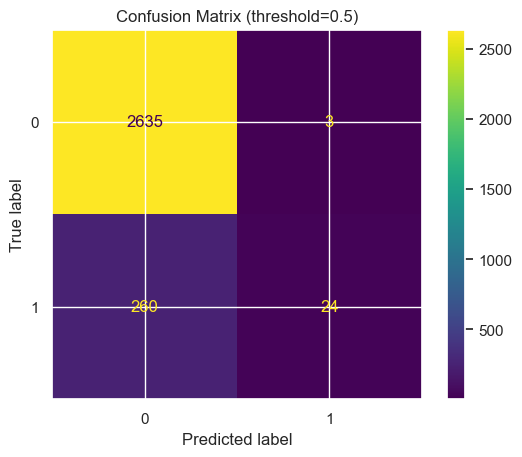

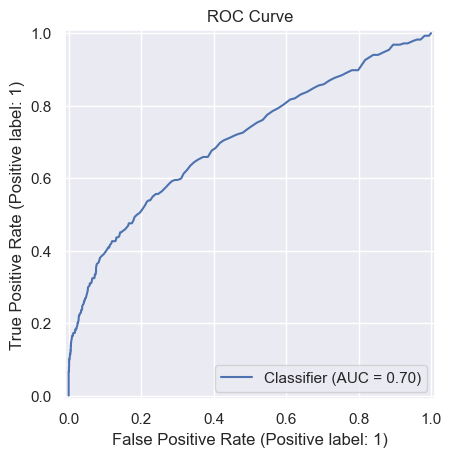

In [48]:
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(confusion_matrix=cm).plot()
plt.title("Confusion Matrix (threshold=0.5)")
plt.show()

RocCurveDisplay.from_predictions(y_test, y_proba)
plt.title("ROC Curve")
plt.savefig("Figure 5.png", dpi=200, bbox_inches="tight")
plt.show()


In [40]:
# Baseline: predict all non-churn
y_base = np.zeros_like(y_test)

acc_b = accuracy_score(y_test, y_base)
prec_b = precision_score(y_test, y_base, zero_division=0)
rec_b = recall_score(y_test, y_base, zero_division=0)
f1_b = f1_score(y_test, y_base, zero_division=0)

print("=== Baseline (predict all non-churn) ===")
print("Accuracy :", round(acc_b, 4))
print("Precision:", round(prec_b, 4))
print("Recall   :", round(rec_b, 4))
print("F1-score :", round(f1_b, 4))


=== Baseline (predict all non-churn) ===
Accuracy : 0.9028
Precision: 0.0
Recall   : 0.0
F1-score : 0.0


# Threshold Tuning

=== Threshold Tuning ===
Best threshold (max F1): 0.194


threshold    0.194000
precision    0.335505
recall       0.362676
f1           0.348562
Name: 97, dtype: float64

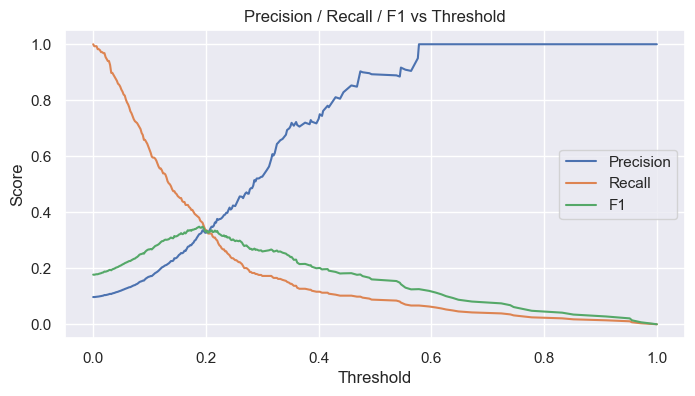

=== Tuned Threshold Performance ===
Threshold: 0.194
Accuracy : 0.8682
Precision: 0.3355
Recall   : 0.3627
F1-score : 0.3486


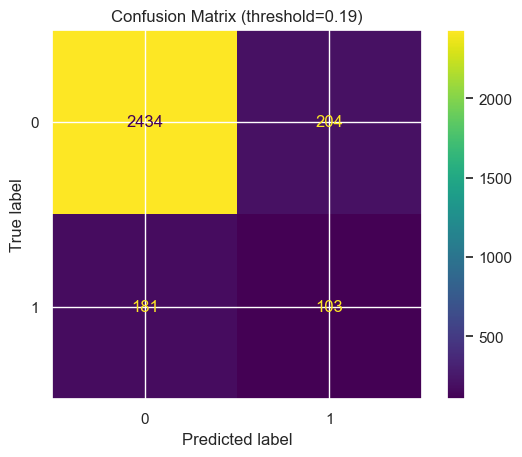

In [43]:
prec_curve, rec_curve, thr = precision_recall_curve(y_test, y_proba)
thr = np.append(thr, 1.0)

df_thr = pd.DataFrame({
    "threshold": thr,
    "precision": prec_curve,
    "recall": rec_curve
})
df_thr["f1"] = 2*(df_thr["precision"]*df_thr["recall"]) / (df_thr["precision"]+df_thr["recall"]+1e-9)

best = df_thr.loc[df_thr["f1"].idxmax()]
best_t = float(best["threshold"])

print("=== Threshold Tuning ===")
print("Best threshold (max F1):", round(best_t, 4))
display(best)

plt.figure(figsize=(8,4))
plt.plot(df_thr["threshold"], df_thr["precision"], label="Precision")
plt.plot(df_thr["threshold"], df_thr["recall"], label="Recall")
plt.plot(df_thr["threshold"], df_thr["f1"], label="F1")
plt.title("Precision / Recall / F1 vs Threshold")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.legend()
plt.show()

y_pred_tuned = (y_proba >= best_t).astype(int)

acc_t = accuracy_score(y_test, y_pred_tuned)
prec_t = precision_score(y_test, y_pred_tuned, zero_division=0)
rec_t = recall_score(y_test, y_pred_tuned, zero_division=0)
f1_t = f1_score(y_test, y_pred_tuned, zero_division=0)

print("=== Tuned Threshold Performance ===")
print("Threshold:", round(best_t, 4))
print("Accuracy :", round(acc_t, 4))
print("Precision:", round(prec_t, 4))
print("Recall   :", round(rec_t, 4))
print("F1-score :", round(f1_t, 4))

cm_t = confusion_matrix(y_test, y_pred_tuned)
ConfusionMatrixDisplay(confusion_matrix=cm_t).plot()
plt.title(f"Confusion Matrix (threshold={best_t:.2f})")
plt.show()


## Feature importance
Random Forest can provide feature importances.  
Because we used one-hot encoding, some categorical variables expand into multiple columns.
We extract the transformed feature names and show the top importances.


Top 20 features:


,feature,importance
0,cons_12m,0.052884
12,margin_net_pow_ele,0.052380
11,margin_gross_pow_ele,0.052008
5,forecast_meter_rent_12m,0.050417
14,net_margin,0.044873
3,forecast_cons_12m,0.044649
2,cons_last_month,0.037041
15,pow_max,0.033308
49,months_activ,0.032711
51,months_modif_prod,0.031125


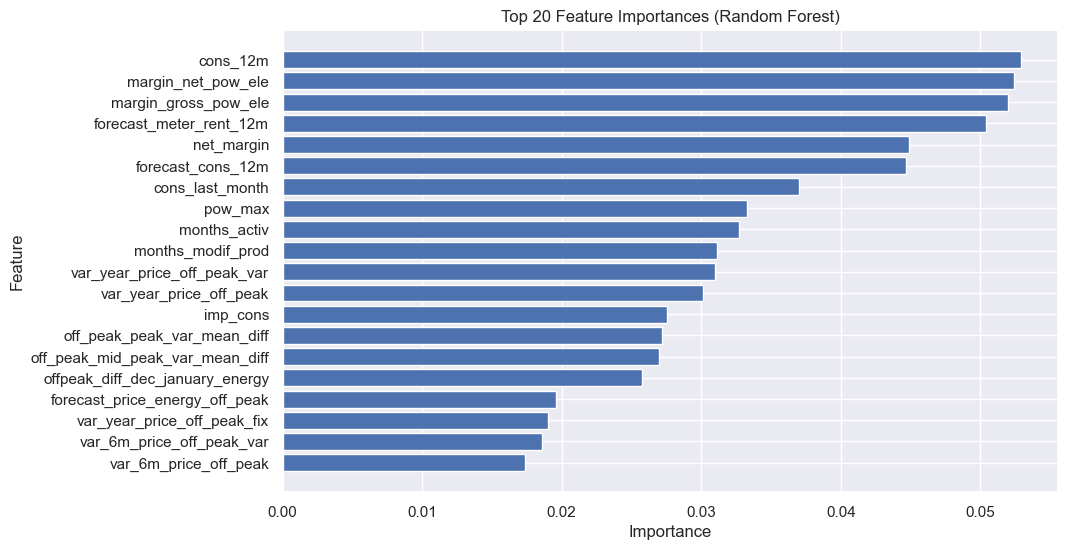

In [49]:
pre = model.named_steps["preprocess"]
rf_model = model.named_steps["rf"]

feature_names = []
feature_names.extend(numeric_features)

if len(categorical_features) > 0:
    ohe = pre.named_transformers_["cat"].named_steps["onehot"]
    ohe_names = ohe.get_feature_names_out(categorical_features).tolist()
    feature_names.extend(ohe_names)

fi = pd.DataFrame({
    "feature": feature_names,
    "importance": rf_model.feature_importances_
}).sort_values("importance", ascending=False)

print("Top 20 features:")
display(fi.head(20))

plt.figure(figsize=(10, 6))
plt.barh(fi.head(20)["feature"][::-1], fi.head(20)["importance"][::-1])
plt.title("Top 20 Feature Importances (Random Forest)")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.savefig("Figure 4.png", dpi=200, bbox_inches="tight")
plt.show()


In [45]:
y_pred_tuned = (y_proba >= best_t).astype(int)

acc_t = accuracy_score(y_test, y_pred_tuned)
prec_t = precision_score(y_test, y_pred_tuned, zero_division=0)
rec_t = recall_score(y_test, y_pred_tuned, zero_division=0)
f1_t = f1_score(y_test, y_pred_tuned, zero_division=0)

print("Best threshold (max F1):", round(best_t, 4))
print("Tuned Accuracy :", round(acc_t, 4))
print("Tuned Precision:", round(prec_t, 4))
print("Tuned Recall   :", round(rec_t, 4))
print("Tuned F1-score :", round(f1_t, 4))


Best threshold (max F1): 0.194
Tuned Accuracy : 0.8682
Tuned Precision: 0.3355
Tuned Recall   : 0.3627
Tuned F1-score : 0.3486


## Model performance summary

### Baseline comparison
A naive baseline that predicts **“no churn”** for every customer achieves **~0.9028 accuracy** but has **0 recall** for churners (it fails to identify any churn customers).  
This demonstrates why accuracy alone is not a reliable metric for churn prediction in an imbalanced dataset.

### Random Forest (default threshold = 0.5)
The Random Forest achieves:
- **ROC-AUC = 0.705**, indicating the model can rank customers by churn risk reasonably well.
- **Precision = 0.8889** and **Recall = 0.0845** for churners.

The high precision but low recall suggests the default 0.5 threshold is too conservative: the model only flags a small number of customers as churn, and while most flagged customers are true churners, it misses the majority of churners.

### Is performance satisfactory?
The model is **directionally useful** because ROC-AUC (~0.71) shows meaningful separation between churn and non-churn customers, and it outperforms the baseline in identifying churners.  
However, the recall at the default threshold is **not satisfactory** for a retention use case, since it captures only ~8% of churners. To make the model operationally useful, we should **tune the classification threshold** (or optimize for recall/F1 depending on business costs) so more churners are detected.


## Final evaluation and business interpretation

### Why these metrics?
Because churn is imbalanced (~10% churners), **accuracy** can be misleading. A model can achieve high accuracy by predicting “no churn” most of the time.  
To properly evaluate churn prediction, we focus on:
- **Recall (churn class):** how many churners we successfully identify (critical for retention)
- **Precision (churn class):** how many predicted churners are truly churners (controls wasted offers)
- **F1-score:** balances precision and recall
- **ROC-AUC:** measures ranking quality across all possible thresholds (useful before choosing an operating point)

### Baseline vs model (default threshold = 0.5)
- **Baseline (predict all non-churn):** Accuracy = **0.9028**, Recall = **0.00**, F1 = **0.00**
- **Random Forest @ 0.5:** Accuracy = **0.91**, Precision = **0.8889**, Recall = **0.0845**, F1 = **0.1543**, ROC-AUC = **0.705**

At the default threshold, the model is very conservative: it rarely predicts churn. This gives high precision but misses most churners.

### Threshold tuning (chosen threshold = 0.194 to maximise F1)
After tuning the decision threshold:
- **Accuracy = 0.8682**
- **Precision = 0.3355**
- **Recall = 0.3627**
- **F1-score = 0.3486**

This improves churn detection substantially:
- Recall increases from **0.0845 → 0.3627** (we catch ~4× more churners),
at the cost of lower precision (more false positives), which is expected in an imbalanced problem.
